In [ ]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.path.dirname(__file__) if '__file__' in dir() else '.', '..')))

import matplotlib.pyplot as plt
from datasets.vdpo_dataset_np import create_vdpo_dataset
from src.nn_pyomo_base import NeuralODEPyomo
import numpy as np
from scipy.interpolate import interp1d

## 1. Create dataset of VDPO state vectors

Full grid shape: (399,)
Y_true shape: (399, 2)
Y_obs shape: (200, 2)
Y_test shape: (200, 2)
Train grid shape: (200,)
Test grid shape: (200,)
Differentiation matrix shape: (200, 200)


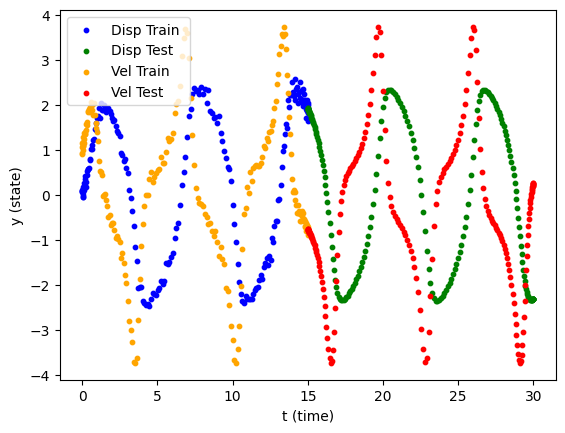

In [ ]:
time_invariant = True
full_grid, Y_true, train_grid, Y_obs, Y_smooth, test_grid, Y_test, D = create_vdpo_dataset(num_nodes=400, end_time=30, noise_sd=0.1, time_invariant=time_invariant)
print(f"Full grid shape: {full_grid.shape}")
print(f"Y_true shape: {Y_true.shape}")
print(f"Y_obs shape: {Y_obs.shape}")
print(f"Y_test shape: {Y_test.shape}")
print(f"Train grid shape: {train_grid.shape}")
print(f"Test grid shape: {test_grid.shape}")
print(f"Differentiation matrix shape: {D.shape}")

# Visualise trajectories from train and test datasets 
plt.figure()
plt.scatter(train_grid, Y_obs[:, 0], color='blue', marker='o', s=10, label="Disp Train ")
plt.scatter(test_grid, Y_test[:, 0], color='green', marker='o', s=10, label="Disp Test")
plt.scatter(train_grid, Y_obs[:, 1], color='orange', marker='o', s=10, label="Vel Train ")
plt.scatter(test_grid, Y_test[:, 1], color='red', marker='o', s=10, label="Vel Test")
plt.xlabel('t (time)')
plt.ylabel('y (state)')
plt.legend()

## 2. Optimise pyomo model using IPOPT (train the neural ODE)

In [ ]:
T = train_grid[-1] - train_grid[0]
if time_invariant:
    layer_sizes = [2, 18, 18, 2]
else:
    layer_sizes = [3, 18, 18, 3]

print(f"T (training interval length): {T:.2f}")
print(f"Y_obs displacement range: [{Y_obs[:, 0].min():.2f}, {Y_obs[:, 0].max():.2f}]")
print(f"Y_obs velocity range: [{Y_obs[:, 1].min():.2f}, {Y_obs[:, 1].max():.2f}]")
print(f"Initial state: {Y_obs[0, :]}")

pyo_model = NeuralODEPyomo(
    Y_obs, D, layer_sizes, 
    state_lower_bound=-100,
    state_upper_bound=100,
    param_lower_bound=-100,
    param_upper_bound=100,
    lambda_reg=0.001,
    Y_smooth=Y_smooth
)
pyo_model.solve_model()

T (training interval length): 15.00
Y_obs displacement range: [-2.47, 2.57]
Y_obs velocity range: [-3.73, 3.73]
Initial state: [0.10780823 1.15817273]
Solver available?: True

Initial NN parameter summary stats (pre-IPOPT): 
Layer 1: W range [-0.5394, 0.7995], |W| mean 0.1931
Layer 1: b range [-0.0477, -0.0477], |b| mean 0.0477
Layer 2: W range [-0.8010, 0.5535], |W| mean 0.1788
Layer 2: b range [-0.0858, -0.0858], |b| mean 0.0858
Layer 3: W range [-0.6921, 0.6522], |W| mean 0.2552
Layer 3: b range [-0.0902, -0.0902], |b| mean 0.0902
Ipopt 3.14.19: max_iter=3000
tol=1e-06
acceptable_tol=0.0001
acceptable_iter=15
nlp_scaling_method=gradient-based
mu_strategy=adaptive
print_level=5


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
***

{'Problem': [{'Lower bound': -inf, 'Upper bound': inf, 'Number of objectives': 1, 'Number of constraints': 400, 'Number of variables': 834, 'Sense': 'unknown'}], 'Solver': [{'Status': 'ok', 'Message': 'Ipopt 3.14.19\\x3a Optimal Solution Found', 'Termination condition': 'optimal', 'Id': 0, 'Error rc': 0, 'Time': 164.5344262123108}], 'Solution': [OrderedDict({'number of solutions': 0, 'number of solutions displayed': 0})]}

## 3. Use the trained model as RHS of an ODE system 

In [ ]:
# run diagnostic methods 
Y_star_values = pyo_model.pyomo_var_to_numpy(pyo_model.model.Y_star, (pyo_model.num_nodes, pyo_model.state_dim))
print(f"Y_star disp range: [{Y_star_values[:, 0].min():.2f}, {Y_star_values[:, 0].max():.2f}]")
print(f"Y_obs disp range: [{Y_obs[:, 0].min():.2f}, {Y_obs[:, 0].max():.2f}]")
print(f"Y_star vel range: [{Y_star_values[:, 1].min():.2f}, {Y_star_values[:, 1].max():.2f}]")
print(f"Max |Y_star - Y_obs|: {np.abs(Y_star_values - Y_obs).max():.4f}\n")
pyo_model.check_ode_residuals(t_grid=train_grid)

y0_train = Y_obs[0, :]
y0_test = Y_test[0, :]
predicted_trajectory_train = pyo_model.get_predicted_trajectory(y0_train, train_grid, rtol=1e-7, atol=1e-9, max_step=(train_grid[1]-train_grid[0]))
predicted_trajectory_test = pyo_model.get_predicted_trajectory(y0_test, test_grid, rtol=1e-7, atol=1e-9, max_step=(test_grid[1]-test_grid[0]))

Y_star disp range: [-2.37, 2.43]
Y_obs disp range: [-2.47, 2.57]
Y_star vel range: [-3.75, 3.65]
Max |Y_star - Y_obs|: 0.3486

ODE residual (all nodes) max: 3.694349
ODE residual (all nodes) mean: 0.015107
ODE residual (constrained nodes 2 -> N) max: 0.000195
ODE residual (constrained nodes 2 -> N) mean: 0.000002
Worst constrained node: n=200, dim=1, |res|=0.000195, t=15.000000


## 4. Plot results

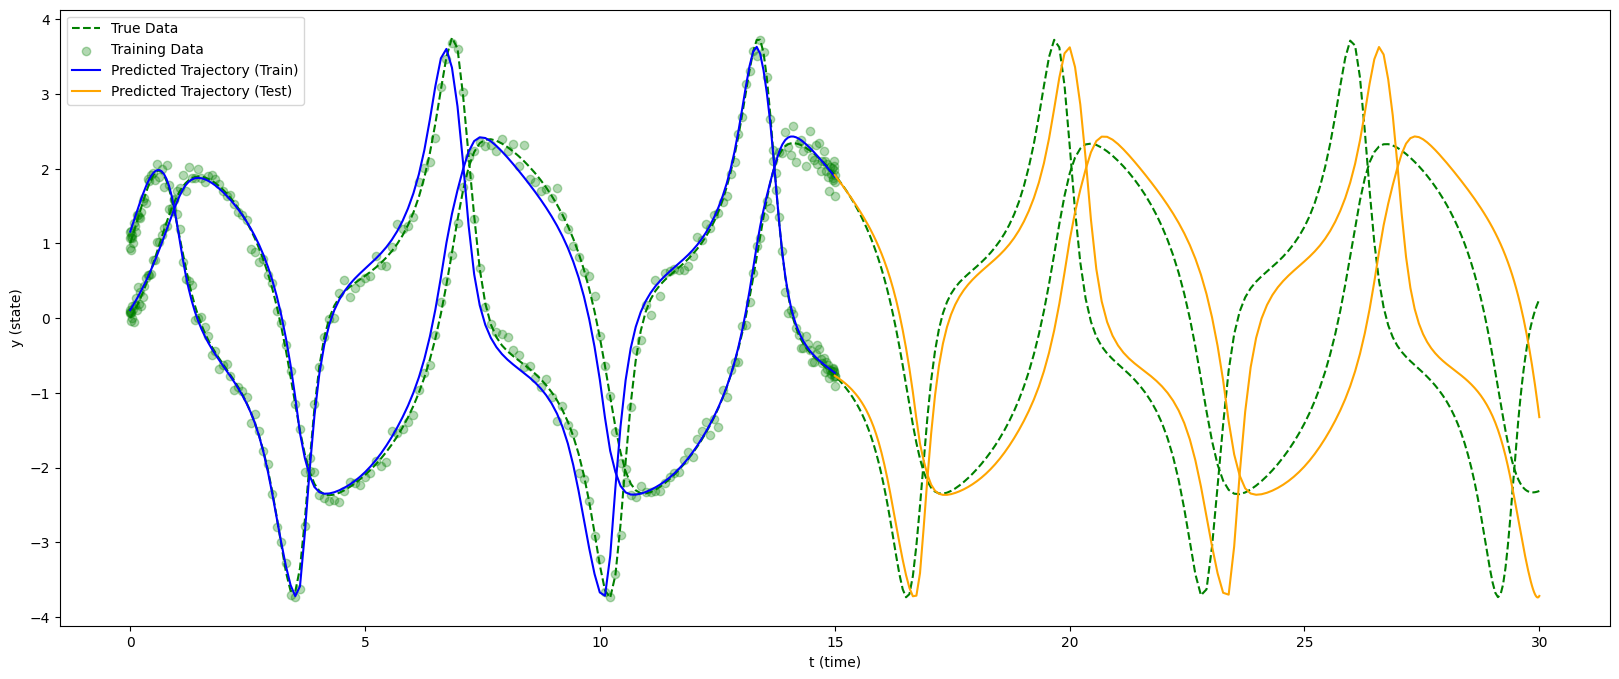

In [ ]:
plt.figure(figsize=(20, 8))

# plot true trajectory 
plt.plot(full_grid, Y_true[:, 0], color='green', linestyle='--', label="True Data")
plt.plot(full_grid, Y_true[:, 1], color='green', linestyle='--')

# plot training data
plt.scatter(train_grid, Y_obs[:, 0], color='green', marker='o', alpha=0.3, label="Training Data")
plt.scatter(train_grid, Y_obs[:, 1], color='green', marker='o', alpha=0.3)

# plot predicted trajectory (train and test)
plt.plot(train_grid, predicted_trajectory_train[:, 0], color='blue', label="Predicted Trajectory (Train)")
plt.plot(train_grid, predicted_trajectory_train[:, 1], color='blue')
plt.plot(test_grid, predicted_trajectory_test[:, 0], color='orange', label="Predicted Trajectory (Test)")
plt.plot(test_grid, predicted_trajectory_test[:, 1], color='orange')

# plot optimised Y_star values at collocation nodes
'''plt.plot(train_grid, Y_star_values[:, 0], 'g-.', linewidth=1, label="$Y_*$ disp")
plt.plot(train_grid, Y_star_values[:, 1], 'r-.', linewidth=1, label="$Y_*$ vel")'''

plt.xlabel('t (time)')
plt.ylabel('y (state)')
plt.legend()